In [10]:
import os
os.listdir("dataset/rawdataset/GSE194078_RAW")

['GSM5827381_KHW_CSF_barcodes.tsv.gz',
 'GSM5827381_KHW_CSF_features.tsv.gz',
 'GSM5827381_KHW_CSF_matrix.mtx.gz',
 'GSM5827382_KHW_PBMC_barcodes.tsv.gz',
 'GSM5827382_KHW_PBMC_features.tsv.gz',
 'GSM5827382_KHW_PBMC_matrix.mtx.gz',
 'GSM5827383_KJS_CSF_barcodes.tsv.gz',
 'GSM5827383_KJS_CSF_features.tsv.gz',
 'GSM5827383_KJS_CSF_matrix.mtx.gz',
 'GSM5827384_KJS_PBMC_barcodes.tsv.gz',
 'GSM5827384_KJS_PBMC_features.tsv.gz',
 'GSM5827384_KJS_PBMC_matrix.mtx.gz',
 'GSM5827385_KSH_CSF_barcodes.tsv.gz',
 'GSM5827385_KSH_CSF_features.tsv.gz',
 'GSM5827385_KSH_CSF_matrix.mtx.gz',
 'GSM5827386_KSH_PBMC_barcodes.tsv.gz',
 'GSM5827386_KSH_PBMC_features.tsv.gz',
 'GSM5827386_KSH_PBMC_matrix.mtx.gz',
 'GSM5827387_KYO_CSF_barcodes.tsv.gz',
 'GSM5827387_KYO_CSF_features.tsv.gz',
 'GSM5827387_KYO_CSF_matrix.mtx.gz',
 'GSM5827388_KYO_PBMC_barcodes.tsv.gz',
 'GSM5827388_KYO_PBMC_features.tsv.gz',
 'GSM5827388_KYO_PBMC_matrix.mtx.gz',
 'GSM5827389_SYG_CSF_barcodes.tsv.gz',
 'GSM5827389_SYG_CSF_features

In [11]:
import os
import gzip
import shutil

data_dir = 'dataset/rawdataset/GSE194078_RAW'
prefixes = set()

for gz_file in os.listdir(data_dir):
    gz_path = os.path.join(data_dir, gz_file)

    # Check if the file is a gzip file
    if not gz_file.endswith('.gz'):
        print(f"Skipping non-gzip file: {gz_file}")
        continue

    # Extract prefix
    for key in ['_barcodes', '_genes', '_matrix']:
        if key in gz_file:
            prefix = gz_file.split(key)[0]
            prefixes.add(prefix)
            break

    # Unzip file
    unzipped_file = gz_file[:-3]  # remove '.gz'
    unzipped_path = os.path.join(data_dir, unzipped_file)

    if not os.path.exists(unzipped_path):  # avoid overwriting
        try:
            with gzip.open(gz_path, 'rb') as f_in, open(
                unzipped_path, 'wb'
            ) as f_out:
                shutil.copyfileobj(f_in, f_out)
                print(f"Unzipped: {unzipped_path}")
        except gzip.BadGzipFile:
            print(f"Failed to unzip (BadGzipFile): {gz_path}")
        except Exception as e:
            print(f"An unexpected error occurred: {e}")
    else:
        print(f"Already unzipped: {unzipped_path}")

print(prefixes)
print(len(prefixes))

Already unzipped: dataset/rawdataset/GSE194078_RAW/GSM5827381_KHW_CSF_barcodes.tsv
Already unzipped: dataset/rawdataset/GSE194078_RAW/GSM5827381_KHW_CSF_features.tsv
Already unzipped: dataset/rawdataset/GSE194078_RAW/GSM5827381_KHW_CSF_matrix.mtx
Already unzipped: dataset/rawdataset/GSE194078_RAW/GSM5827382_KHW_PBMC_barcodes.tsv
Already unzipped: dataset/rawdataset/GSE194078_RAW/GSM5827382_KHW_PBMC_features.tsv
Already unzipped: dataset/rawdataset/GSE194078_RAW/GSM5827382_KHW_PBMC_matrix.mtx
Already unzipped: dataset/rawdataset/GSE194078_RAW/GSM5827383_KJS_CSF_barcodes.tsv
Already unzipped: dataset/rawdataset/GSE194078_RAW/GSM5827383_KJS_CSF_features.tsv
Already unzipped: dataset/rawdataset/GSE194078_RAW/GSM5827383_KJS_CSF_matrix.mtx
Already unzipped: dataset/rawdataset/GSE194078_RAW/GSM5827384_KJS_PBMC_barcodes.tsv
Already unzipped: dataset/rawdataset/GSE194078_RAW/GSM5827384_KJS_PBMC_features.tsv
Already unzipped: dataset/rawdataset/GSE194078_RAW/GSM5827384_KJS_PBMC_matrix.mtx
Alread

In [12]:
import GEOparse
import pandas as pd
import scanpy as sc

# Set the GSE ID
gse_id = "GSE194078"


def get_geo_data(gse_id):
    # Download and parse the GEO data
    gse = GEOparse.get_GEO(geo=gse_id, destdir=".", annotate_gpl=True, silent=True)

    # Extract sample metadata for all GSMs
    all_sample_metadata = []
    for gsm_id, gsm in gse.gsms.items():
        metadata = gsm.metadata
        sample_metadata = {
            "title": metadata["title"][0],
            "geo_accession": metadata["geo_accession"][0],
            "disease": metadata["characteristics_ch1"][2].split(": ")[1],
            "patient_id": metadata["characteristics_ch1"][0].split(": ")[1],
            "tissue": metadata["characteristics_ch1"][1].split(": ")[1],
        }
        all_sample_metadata.append(sample_metadata)

    sample_metadata_df = pd.DataFrame(all_sample_metadata)

    return sample_metadata_df




In [13]:
import re
import celltypist
from celltypist import models
import scanpy as sc
import pandas as pd
def parse_sample_name(sample_name):
    match = re.search(r'GSM(\d+)_([A-Z]{2,3})_(CSF|PBMC)', sample_name)
    if match:
        gsm_number = match.group(1)
        patient_code_type = match.group(2)
        patient_code = match.group(3)
        return gsm_number, patient_code_type, patient_code
    else:
        return None, None, None


    

def process_adata(adata):
    print(adata)
    sc.pp.normalize_total(adata, target_sum=1e4)
    # Logarithmize the data
    sc.pp.log1p(adata)
    # Mitochondrial genes, "MT-" for human, "Mt-" for mouse
    adata.var["mt"] = adata.var_names.str.startswith("MT-")
    sc.pp.calculate_qc_metrics(
        adata, qc_vars=["mt"], inplace=True, log1p=True
    )
    # Filtering
    sc.pp.filter_cells(adata, max_genes=6000)
    sc.pp.filter_cells(adata, max_counts=35000)
    sc.pp.filter_cells(adata, min_genes=100)
    adata = adata[adata.obs['pct_counts_mt'] < 10, :]
    adata.layers["counts"] = adata.X.copy()
    # Normalizing to median total counts
    
    return adata

def annotate_adata(adata):
    predictions = celltypist.annotate(adata.copy(), model = 'Adult_COVID19_PBMC.pkl', majority_voting = True)
    adata.obs = pd.concat([adata.obs, predictions.predicted_labels], axis=1)
    return adata
    
adata_list = []
geo = get_geo_data("GSE194078")
for prefix in prefixes:
    adata = sc.read_10x_mtx("dataset/rawdataset/GSE194078_RAW/",
                            prefix=prefix+"_")

    # Parse the sample name to get condition, sample, and tissue
    patient_code_type, patient_code, tissue = parse_sample_name(prefix)

    patient_code_type = "GSM"+patient_code_type
    
    match = geo[geo['geo_accession'] == patient_code_type]

    adata.obs['condition'] = match['disease'].iloc[0]
    adata.obs['sample'] = match['title'].iloc[0]
    adata.obs['tissue'] = match['tissue'].iloc[0]

    adata = process_adata(adata)
    adata = annotate_adata(adata)
    print(adata)
    adata_list.append(adata)

AnnData object with n_obs × n_vars = 10319 × 36601
    obs: 'condition', 'sample', 'tissue'
    var: 'gene_ids', 'feature_types'


🔬 Input data has 10255 cells and 36601 genes
🔗 Matching reference genes in the model
🧬 3017 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Can not detect a neighborhood graph, will construct one before the over-clustering
⛓️ Over-clustering input data with resolution set to 10
🗳️ Majority voting the predictions
✅ Majority voting done!


AnnData object with n_obs × n_vars = 10255 × 36601
    obs: 'condition', 'sample', 'tissue', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'n_genes', 'n_counts', 'predicted_labels', 'over_clustering', 'majority_voting'
    var: 'gene_ids', 'feature_types', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'log1p'
    layers: 'counts'
AnnData object with n_obs × n_vars = 395 × 36601
    obs: 'condition', 'sample', 'tissue'
    var: 'gene_ids', 'feature_types'


🔬 Input data has 388 cells and 36601 genes
🔗 Matching reference genes in the model
🧬 3017 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Can not detect a neighborhood graph, will construct one before the over-clustering
⛓️ Over-clustering input data with resolution set to 5
🗳️ Majority voting the predictions
✅ Majority voting done!


AnnData object with n_obs × n_vars = 388 × 36601
    obs: 'condition', 'sample', 'tissue', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'n_genes', 'n_counts', 'predicted_labels', 'over_clustering', 'majority_voting'
    var: 'gene_ids', 'feature_types', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'log1p'
    layers: 'counts'
AnnData object with n_obs × n_vars = 13241 × 36601
    obs: 'condition', 'sample', 'tissue'
    var: 'gene_ids', 'feature_types'


🔬 Input data has 13105 cells and 36601 genes
🔗 Matching reference genes in the model
🧬 3017 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Can not detect a neighborhood graph, will construct one before the over-clustering
⛓️ Over-clustering input data with resolution set to 10
🗳️ Majority voting the predictions
✅ Majority voting done!


AnnData object with n_obs × n_vars = 13105 × 36601
    obs: 'condition', 'sample', 'tissue', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'n_genes', 'n_counts', 'predicted_labels', 'over_clustering', 'majority_voting'
    var: 'gene_ids', 'feature_types', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'log1p'
    layers: 'counts'
AnnData object with n_obs × n_vars = 16133 × 36601
    obs: 'condition', 'sample', 'tissue'
    var: 'gene_ids', 'feature_types'


🔬 Input data has 15821 cells and 36601 genes
🔗 Matching reference genes in the model
🧬 3017 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Can not detect a neighborhood graph, will construct one before the over-clustering
⛓️ Over-clustering input data with resolution set to 10
🗳️ Majority voting the predictions
✅ Majority voting done!


AnnData object with n_obs × n_vars = 15821 × 36601
    obs: 'condition', 'sample', 'tissue', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'n_genes', 'n_counts', 'predicted_labels', 'over_clustering', 'majority_voting'
    var: 'gene_ids', 'feature_types', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'log1p'
    layers: 'counts'
AnnData object with n_obs × n_vars = 9748 × 36601
    obs: 'condition', 'sample', 'tissue'
    var: 'gene_ids', 'feature_types'


🔬 Input data has 9720 cells and 36601 genes
🔗 Matching reference genes in the model
🧬 3017 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Can not detect a neighborhood graph, will construct one before the over-clustering
⛓️ Over-clustering input data with resolution set to 10
🗳️ Majority voting the predictions
✅ Majority voting done!


AnnData object with n_obs × n_vars = 9720 × 36601
    obs: 'condition', 'sample', 'tissue', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'n_genes', 'n_counts', 'predicted_labels', 'over_clustering', 'majority_voting'
    var: 'gene_ids', 'feature_types', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'log1p'
    layers: 'counts'
AnnData object with n_obs × n_vars = 8963 × 36601
    obs: 'condition', 'sample', 'tissue'
    var: 'gene_ids', 'feature_types'


🔬 Input data has 8942 cells and 36601 genes
🔗 Matching reference genes in the model
🧬 3017 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Can not detect a neighborhood graph, will construct one before the over-clustering
⛓️ Over-clustering input data with resolution set to 10
🗳️ Majority voting the predictions
✅ Majority voting done!


AnnData object with n_obs × n_vars = 8942 × 36601
    obs: 'condition', 'sample', 'tissue', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'n_genes', 'n_counts', 'predicted_labels', 'over_clustering', 'majority_voting'
    var: 'gene_ids', 'feature_types', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'log1p'
    layers: 'counts'
AnnData object with n_obs × n_vars = 9178 × 36601
    obs: 'condition', 'sample', 'tissue'
    var: 'gene_ids', 'feature_types'


🔬 Input data has 8888 cells and 36601 genes
🔗 Matching reference genes in the model
🧬 3017 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Can not detect a neighborhood graph, will construct one before the over-clustering
⛓️ Over-clustering input data with resolution set to 10
🗳️ Majority voting the predictions
✅ Majority voting done!


AnnData object with n_obs × n_vars = 8888 × 36601
    obs: 'condition', 'sample', 'tissue', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'n_genes', 'n_counts', 'predicted_labels', 'over_clustering', 'majority_voting'
    var: 'gene_ids', 'feature_types', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'log1p'
    layers: 'counts'
AnnData object with n_obs × n_vars = 1917 × 36601
    obs: 'condition', 'sample', 'tissue'
    var: 'gene_ids', 'feature_types'


🔬 Input data has 1875 cells and 36601 genes
🔗 Matching reference genes in the model
🧬 3017 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Can not detect a neighborhood graph, will construct one before the over-clustering
⛓️ Over-clustering input data with resolution set to 5
🗳️ Majority voting the predictions
✅ Majority voting done!


AnnData object with n_obs × n_vars = 1875 × 36601
    obs: 'condition', 'sample', 'tissue', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'n_genes', 'n_counts', 'predicted_labels', 'over_clustering', 'majority_voting'
    var: 'gene_ids', 'feature_types', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'log1p'
    layers: 'counts'
AnnData object with n_obs × n_vars = 2641 × 36601
    obs: 'condition', 'sample', 'tissue'
    var: 'gene_ids', 'feature_types'


🔬 Input data has 2633 cells and 36601 genes
🔗 Matching reference genes in the model
🧬 3017 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Can not detect a neighborhood graph, will construct one before the over-clustering
⛓️ Over-clustering input data with resolution set to 5
🗳️ Majority voting the predictions
✅ Majority voting done!


AnnData object with n_obs × n_vars = 2633 × 36601
    obs: 'condition', 'sample', 'tissue', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'n_genes', 'n_counts', 'predicted_labels', 'over_clustering', 'majority_voting'
    var: 'gene_ids', 'feature_types', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'log1p'
    layers: 'counts'
AnnData object with n_obs × n_vars = 2887 × 36601
    obs: 'condition', 'sample', 'tissue'
    var: 'gene_ids', 'feature_types'


🔬 Input data has 2867 cells and 36601 genes
🔗 Matching reference genes in the model
🧬 3017 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Can not detect a neighborhood graph, will construct one before the over-clustering
⛓️ Over-clustering input data with resolution set to 5
🗳️ Majority voting the predictions
✅ Majority voting done!


AnnData object with n_obs × n_vars = 2867 × 36601
    obs: 'condition', 'sample', 'tissue', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'n_genes', 'n_counts', 'predicted_labels', 'over_clustering', 'majority_voting'
    var: 'gene_ids', 'feature_types', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'log1p'
    layers: 'counts'
AnnData object with n_obs × n_vars = 10079 × 36601
    obs: 'condition', 'sample', 'tissue'
    var: 'gene_ids', 'feature_types'


🔬 Input data has 10069 cells and 36601 genes
🔗 Matching reference genes in the model
🧬 3017 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Can not detect a neighborhood graph, will construct one before the over-clustering
⛓️ Over-clustering input data with resolution set to 10
🗳️ Majority voting the predictions
✅ Majority voting done!


AnnData object with n_obs × n_vars = 10069 × 36601
    obs: 'condition', 'sample', 'tissue', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'n_genes', 'n_counts', 'predicted_labels', 'over_clustering', 'majority_voting'
    var: 'gene_ids', 'feature_types', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'log1p'
    layers: 'counts'
AnnData object with n_obs × n_vars = 11289 × 36601
    obs: 'condition', 'sample', 'tissue'
    var: 'gene_ids', 'feature_types'


🔬 Input data has 11087 cells and 36601 genes
🔗 Matching reference genes in the model
🧬 3017 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Can not detect a neighborhood graph, will construct one before the over-clustering
⛓️ Over-clustering input data with resolution set to 10
🗳️ Majority voting the predictions
✅ Majority voting done!


AnnData object with n_obs × n_vars = 11087 × 36601
    obs: 'condition', 'sample', 'tissue', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'n_genes', 'n_counts', 'predicted_labels', 'over_clustering', 'majority_voting'
    var: 'gene_ids', 'feature_types', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'log1p'
    layers: 'counts'
AnnData object with n_obs × n_vars = 1849 × 36601
    obs: 'condition', 'sample', 'tissue'
    var: 'gene_ids', 'feature_types'


🔬 Input data has 1833 cells and 36601 genes
🔗 Matching reference genes in the model
🧬 3017 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Can not detect a neighborhood graph, will construct one before the over-clustering
⛓️ Over-clustering input data with resolution set to 5
🗳️ Majority voting the predictions
✅ Majority voting done!


AnnData object with n_obs × n_vars = 1833 × 36601
    obs: 'condition', 'sample', 'tissue', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'n_genes', 'n_counts', 'predicted_labels', 'over_clustering', 'majority_voting'
    var: 'gene_ids', 'feature_types', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'log1p'
    layers: 'counts'
AnnData object with n_obs × n_vars = 1996 × 36601
    obs: 'condition', 'sample', 'tissue'
    var: 'gene_ids', 'feature_types'


🔬 Input data has 1968 cells and 36601 genes
🔗 Matching reference genes in the model
🧬 3017 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Can not detect a neighborhood graph, will construct one before the over-clustering
⛓️ Over-clustering input data with resolution set to 5
🗳️ Majority voting the predictions
✅ Majority voting done!


AnnData object with n_obs × n_vars = 1968 × 36601
    obs: 'condition', 'sample', 'tissue', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'n_genes', 'n_counts', 'predicted_labels', 'over_clustering', 'majority_voting'
    var: 'gene_ids', 'feature_types', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'log1p'
    layers: 'counts'
AnnData object with n_obs × n_vars = 10394 × 36601
    obs: 'condition', 'sample', 'tissue'
    var: 'gene_ids', 'feature_types'


🔬 Input data has 10387 cells and 36601 genes
🔗 Matching reference genes in the model
🧬 3017 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Can not detect a neighborhood graph, will construct one before the over-clustering
⛓️ Over-clustering input data with resolution set to 10
🗳️ Majority voting the predictions
✅ Majority voting done!


AnnData object with n_obs × n_vars = 10387 × 36601
    obs: 'condition', 'sample', 'tissue', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'n_genes', 'n_counts', 'predicted_labels', 'over_clustering', 'majority_voting'
    var: 'gene_ids', 'feature_types', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'log1p'
    layers: 'counts'
AnnData object with n_obs × n_vars = 3827 × 36601
    obs: 'condition', 'sample', 'tissue'
    var: 'gene_ids', 'feature_types'


🔬 Input data has 3812 cells and 36601 genes
🔗 Matching reference genes in the model
🧬 3017 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Can not detect a neighborhood graph, will construct one before the over-clustering
⛓️ Over-clustering input data with resolution set to 5
🗳️ Majority voting the predictions
✅ Majority voting done!


AnnData object with n_obs × n_vars = 3812 × 36601
    obs: 'condition', 'sample', 'tissue', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'n_genes', 'n_counts', 'predicted_labels', 'over_clustering', 'majority_voting'
    var: 'gene_ids', 'feature_types', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'log1p'
    layers: 'counts'


🔬 Input data has 324 cells and 36601 genes
🔗 Matching reference genes in the model


AnnData object with n_obs × n_vars = 329 × 36601
    obs: 'condition', 'sample', 'tissue'
    var: 'gene_ids', 'feature_types'


🧬 3017 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Can not detect a neighborhood graph, will construct one before the over-clustering
⛓️ Over-clustering input data with resolution set to 5
🗳️ Majority voting the predictions
✅ Majority voting done!


AnnData object with n_obs × n_vars = 324 × 36601
    obs: 'condition', 'sample', 'tissue', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'n_genes', 'n_counts', 'predicted_labels', 'over_clustering', 'majority_voting'
    var: 'gene_ids', 'feature_types', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'log1p'
    layers: 'counts'
AnnData object with n_obs × n_vars = 7640 × 36601
    obs: 'condition', 'sample', 'tissue'
    var: 'gene_ids', 'feature_types'


🔬 Input data has 7531 cells and 36601 genes
🔗 Matching reference genes in the model
🧬 3017 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Can not detect a neighborhood graph, will construct one before the over-clustering
⛓️ Over-clustering input data with resolution set to 10
🗳️ Majority voting the predictions
✅ Majority voting done!


AnnData object with n_obs × n_vars = 7531 × 36601
    obs: 'condition', 'sample', 'tissue', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'n_genes', 'n_counts', 'predicted_labels', 'over_clustering', 'majority_voting'
    var: 'gene_ids', 'feature_types', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'log1p'
    layers: 'counts'
AnnData object with n_obs × n_vars = 11823 × 36601
    obs: 'condition', 'sample', 'tissue'
    var: 'gene_ids', 'feature_types'


🔬 Input data has 11634 cells and 36601 genes
🔗 Matching reference genes in the model
🧬 3017 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Can not detect a neighborhood graph, will construct one before the over-clustering
⛓️ Over-clustering input data with resolution set to 10
🗳️ Majority voting the predictions
✅ Majority voting done!


AnnData object with n_obs × n_vars = 11634 × 36601
    obs: 'condition', 'sample', 'tissue', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'n_genes', 'n_counts', 'predicted_labels', 'over_clustering', 'majority_voting'
    var: 'gene_ids', 'feature_types', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'log1p'
    layers: 'counts'
AnnData object with n_obs × n_vars = 9621 × 36601
    obs: 'condition', 'sample', 'tissue'
    var: 'gene_ids', 'feature_types'


🔬 Input data has 9388 cells and 36601 genes
🔗 Matching reference genes in the model
🧬 3017 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Can not detect a neighborhood graph, will construct one before the over-clustering
⛓️ Over-clustering input data with resolution set to 10
🗳️ Majority voting the predictions
✅ Majority voting done!


AnnData object with n_obs × n_vars = 9388 × 36601
    obs: 'condition', 'sample', 'tissue', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'n_genes', 'n_counts', 'predicted_labels', 'over_clustering', 'majority_voting'
    var: 'gene_ids', 'feature_types', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'log1p'
    layers: 'counts'
AnnData object with n_obs × n_vars = 8528 × 36601
    obs: 'condition', 'sample', 'tissue'
    var: 'gene_ids', 'feature_types'


🔬 Input data has 8501 cells and 36601 genes
🔗 Matching reference genes in the model
🧬 3017 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Can not detect a neighborhood graph, will construct one before the over-clustering
⛓️ Over-clustering input data with resolution set to 10
🗳️ Majority voting the predictions
✅ Majority voting done!


AnnData object with n_obs × n_vars = 8501 × 36601
    obs: 'condition', 'sample', 'tissue', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'n_genes', 'n_counts', 'predicted_labels', 'over_clustering', 'majority_voting'
    var: 'gene_ids', 'feature_types', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'log1p'
    layers: 'counts'
AnnData object with n_obs × n_vars = 11138 × 36601
    obs: 'condition', 'sample', 'tissue'
    var: 'gene_ids', 'feature_types'


🔬 Input data has 11115 cells and 36601 genes
🔗 Matching reference genes in the model
🧬 3017 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Can not detect a neighborhood graph, will construct one before the over-clustering
⛓️ Over-clustering input data with resolution set to 10
🗳️ Majority voting the predictions
✅ Majority voting done!


AnnData object with n_obs × n_vars = 11115 × 36601
    obs: 'condition', 'sample', 'tissue', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'n_genes', 'n_counts', 'predicted_labels', 'over_clustering', 'majority_voting'
    var: 'gene_ids', 'feature_types', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'log1p'
    layers: 'counts'


In [14]:
import anndata
adata = anndata.concat(adata_list, join='inner', merge="same")
print(adata)

AnnData object with n_obs × n_vars = 162143 × 36601
    obs: 'condition', 'sample', 'tissue', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'n_genes', 'n_counts', 'predicted_labels', 'over_clustering', 'majority_voting'
    var: 'gene_ids', 'feature_types', 'mt'
    layers: 'counts'


... storing 'condition' as categorical
... storing 'sample' as categorical
... storing 'tissue' as categorical
... storing 'feature_types' as categorical


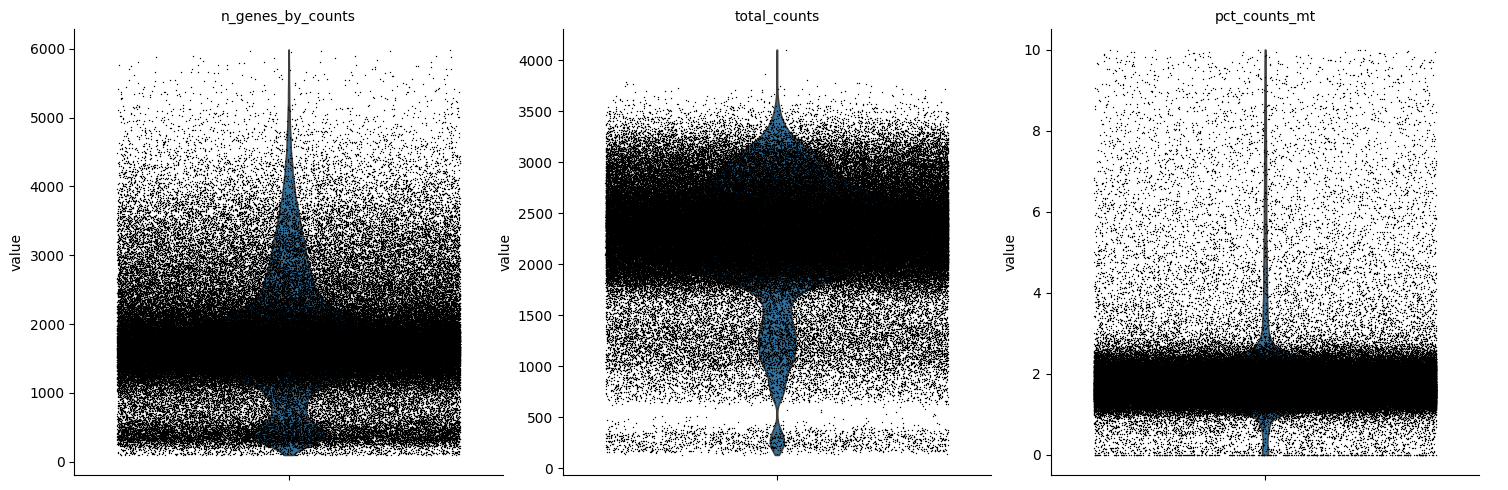

In [15]:
sc.pl.violin(
    adata,
    ["n_genes_by_counts", "total_counts", "pct_counts_mt"],
    jitter=0.4,
    multi_panel=True,
)

In [16]:
import numpy as np
def remove_zero_expressed_genes(adata):
  """
  Removes genes with zero expression in all cells from an AnnData object.

  Args:
    adata: An AnnData object.

  Returns:
    An AnnData object with zero-expressed genes removed.
  """
  # Calculate the mean expression for each gene
  gene_means = adata.X.mean(axis=0)
  
  # Identify genes with zero mean expression
  zero_expressed_genes = gene_means == 0

  # Get the indices of the genes to keep
  genes_to_keep = ~zero_expressed_genes

  # Subset the AnnData object to keep only the genes with non-zero expression
  adata = adata[:, genes_to_keep]

  print(f"Removed {np.sum(zero_expressed_genes)} genes with zero expression.")
  return adata
adata = remove_zero_expressed_genes(adata)
print(adata)

Removed 6720 genes with zero expression.
View of AnnData object with n_obs × n_vars = 162143 × 29881
    obs: 'condition', 'sample', 'tissue', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'n_genes', 'n_counts', 'predicted_labels', 'over_clustering', 'majority_voting'
    var: 'gene_ids', 'feature_types', 'mt'
    layers: 'counts'


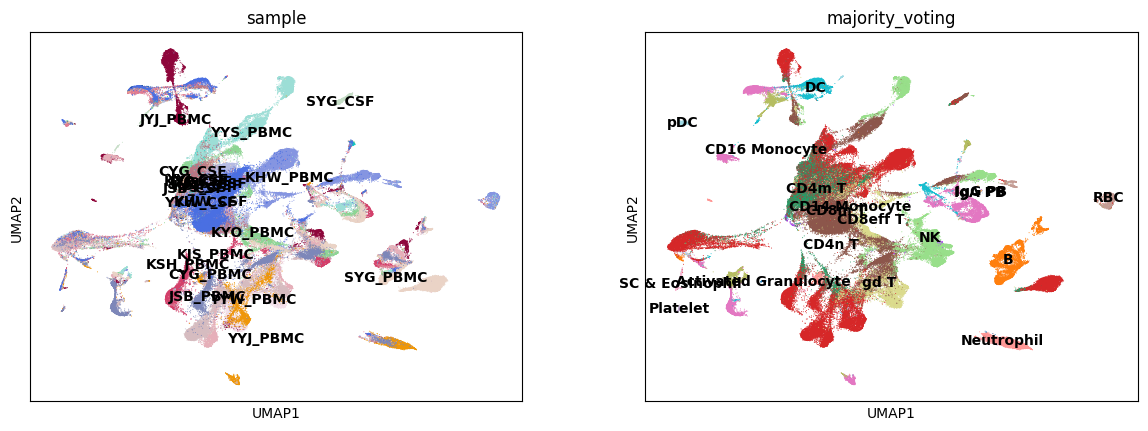

In [17]:
import rapids_singlecell as rsc
rsc.tl.pca(adata, svd_solver='arpack', n_comps=50)
rsc.pp.neighbors(adata, n_neighbors=15, n_pcs=30)
rsc.tl.umap(adata, min_dist=0.3, spread=1.0)

sc.pl.umap(
    adata,
    color=["sample", "majority_voting"],
    # Setting a smaller point size to get prevent overlap
    size=2,
    legend_loc = 'on data'
)

In [18]:
adata.write("dataset/rawdataset/gse104078.finale.h5ad", compression="gzip")

In [19]:
import scanpy as sc

# Load the AnnData object
adata = sc.read_h5ad("dataset/rawdataset/gse104078.finale.h5ad")

# Filter the AnnData object to keep only cells where 'tissue' == 'PBMC'
adata = adata[adata.obs['tissue'] == 'PBMC', :]

# (Optional) Print the shape of the filtered AnnData object to confirm
print(f"Shape of filtered AnnData object: {adata.shape}")

# (Optional) Save the filtered AnnData object to a new file
adata.write("dataset/rawdataset/gse104078.finale.pbmc.h5ad", compression="gzip")

Shape of filtered AnnData object: (113854, 29881)


In [21]:
adata.obs['condition'].unique()

['Ab-mediated IDD', 'MS', 'Normal']
Categories (3, object): ['Ab-mediated IDD', 'MS', 'Normal']

In [22]:
import anndata as ad

# Assuming your AnnData object is named 'adata'
adata = adata[adata.obs['condition'].isin(['MS', 'Normal'])]

# Replace 'Normal' with 'CTRL'
adata.obs['condition'] = adata.obs['condition'].replace('Normal', 'CTRL')

print(adata.obs['condition'].unique())
adata.write("dataset/rawdataset/gse104078.finale.pbmc.h5ad", compression="gzip")

['MS', 'CTRL']
Categories (2, object): ['MS', 'CTRL']


In [1]:
import anndata
import scanpy as sc
# Load the AnnData object
adata = sc.read_h5ad("../dataset/rawdataset/gse104078.finale.h5ad")
adata

/usr/local/lib/python3.10/dist-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


AnnData object with n_obs × n_vars = 162143 × 29881
    obs: 'condition', 'sample', 'tissue', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'n_genes', 'n_counts', 'predicted_labels', 'over_clustering', 'majority_voting'
    var: 'gene_ids', 'feature_types', 'mt'
    uns: 'majority_voting_colors', 'neighbors', 'pca', 'sample_colors', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

In [4]:
# Assuming your AnnData object is named 'adata'
adata = adata[adata.obs['condition'].isin(['MS', 'Normal'])]
adata.obs['condition'] = adata.obs['condition'].replace('Normal', 'CTRL')
adata = adata[adata.obs['tissue'] == 'CSF', :]
adata


/tmp/ipykernel_1036729/2586320446.py:3: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  adata.obs['condition'] = adata.obs['condition'].replace('Normal', 'CTRL')
/tmp/ipykernel_1036729/2586320446.py:3: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['condition'] = adata.obs['condition'].replace('Normal', 'CTRL')
/usr/local/lib/python3.10/dist-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


View of AnnData object with n_obs × n_vars = 19329 × 29881
    obs: 'condition', 'sample', 'tissue', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'n_genes', 'n_counts', 'predicted_labels', 'over_clustering', 'majority_voting'
    var: 'gene_ids', 'feature_types', 'mt'
    uns: 'majority_voting_colors', 'neighbors', 'pca', 'sample_colors', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

In [6]:
adata.write("../dataset/rawdataset/gse104078.finale.csf.h5ad", compression="gzip")